In [1]:
import numpy as np
import pandas as pd
import altair as alt

import sys
sys.path.append("../src")

from io_utils import *
from pcp import *
from metrics import *
from viz import *

### 1. Load data
Here, every image should be resized to height = 128 and width = 256. Every single image becomes an array with such dimensions. This is important for PCP because matrices need consisten shapes and it simplifies batching and comparisons across images.

load_dawn_images is finding all image files. For each file:
- Open the image with Pillow.
- Convert to grayscale
- Resize
- Convert to a numpy array of type float32
- Normalize pizel values to [0, 1]

In [2]:
root_dir = "../data/images"
data_dict = load_dawn_images(root_dir, target_size=(128, 256), max_per_category=None)

### 2. Run PCP per category
This step takes all the preprocessed images and runs Principal Component Pursuit (PCP) on each image individually. 
The purpose is to decompose every image $X$ into:
- Low-rank $L$ component: the underlying scene
- Sparse $S$ component: weather artifacts (rain streals, snow dots, noise)
The results will be organized in a dictionary so we can later compare weather categories, generate plots and inspect representative decompositions.

In [3]:
# 2. Run PCP per category
all_results = {}
pcp_kwargs = {
    "lam": None,        # Weight for sparsity penalty. Use default 1/sqrt(max(m,n)) to use Cande's et al. suggestion.
    "mu": None,         # Augmented Lagrangian parameter. If None, set to 1.25 / norm(X, 2)
    "max_iters": 1000,  # Maximum number of iterations for the PCP solver per image.
    "tol": 1e-4,        # Tolerance for convergence. Stop when ||X - L - S||_F / ||X||_F < tol
    "verbose": False,   # Whether to print progress during PCP.
}

for weather, images in data_dict.items():
    print(f"Running PCP for weather category: {weather} (n={len(images)})")
    all_results[weather] = summarize_category(images, pcp_kwargs=pcp_kwargs)

Running PCP for weather category: dusttornado (n=36)
Running PCP for weather category: foggy (n=104)
Running PCP for weather category: haze (n=114)
Running PCP for weather category: mist (n=82)
Running PCP for weather category: rain_storm (n=200)
Running PCP for weather category: sand_storm (n=287)
Running PCP for weather category: snow_storm (n=204)


What does summarize_category do?

For each image $X$ in each category:
1. Runs L, S, info = pcp_inexact_alm(X, **pcp_kwargs).
2. Computes
   1. Reconstruction error
   2. Singular values of X
   3. Singular values of L
3. Stores everything in a dictionary
4. Appends it to a list for that category

### 3. Qualitative inspection
Loop through categories, pick an example from each category and visualize its decomposition. Each image will have:

Row 1:
1. Original $X$
2. Low-rank $L$
3. Raw sparse $S$

Row 2:
1. $S$ rescaled to [0, 1]
2. $S$ in sesimic colors, tight dynamic range
3. Original image + mask overlay of high-|S| pixels


Representative (median-rank) decomposition for dusttornado


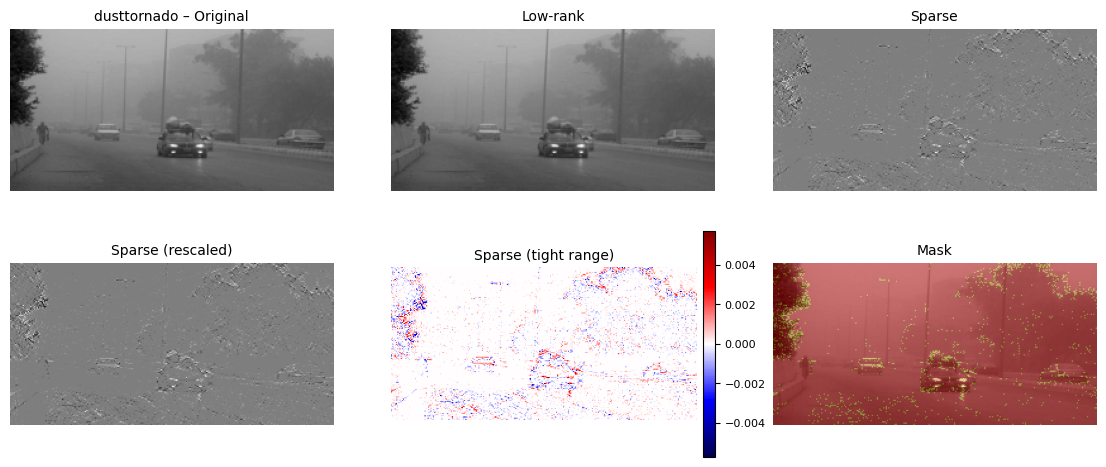


Representative (median-rank) decomposition for foggy


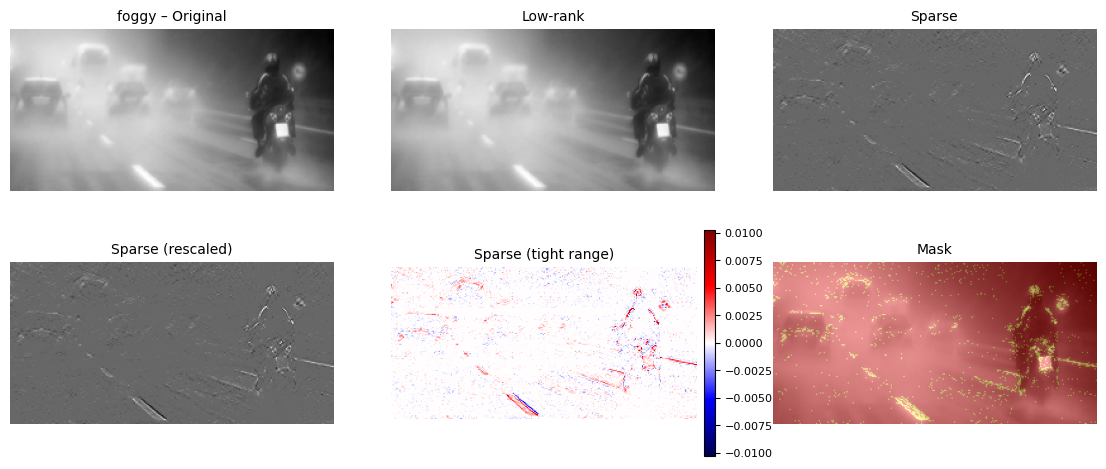


Representative (median-rank) decomposition for haze


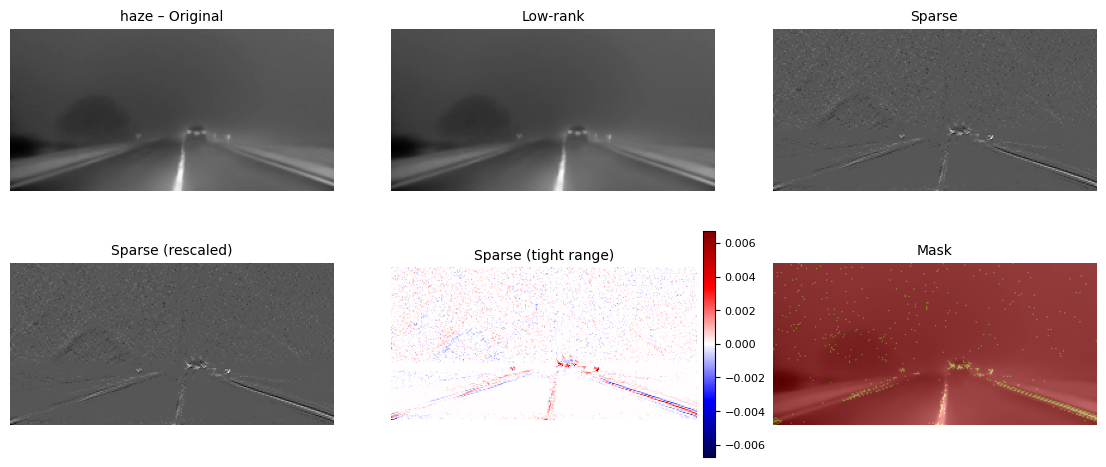


Representative (median-rank) decomposition for mist


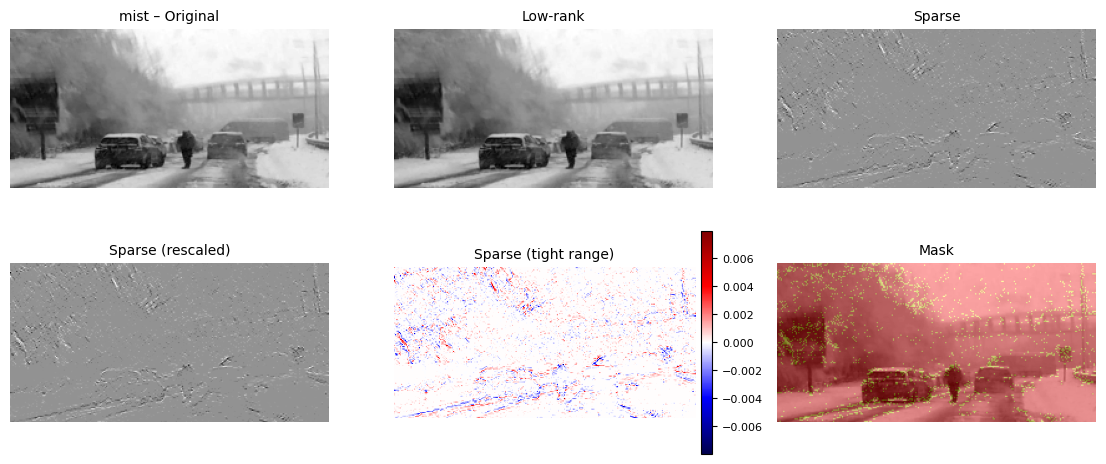


Representative (median-rank) decomposition for rain_storm


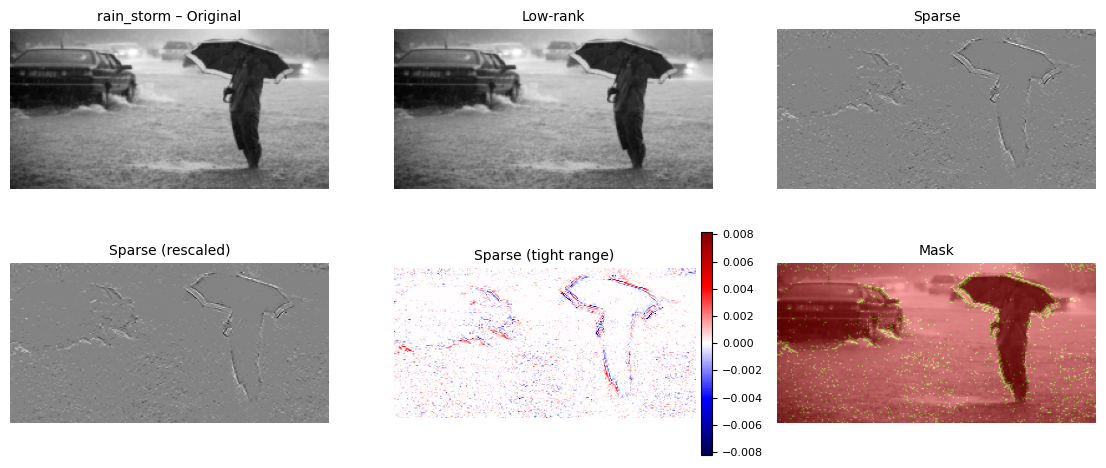


Representative (median-rank) decomposition for sand_storm


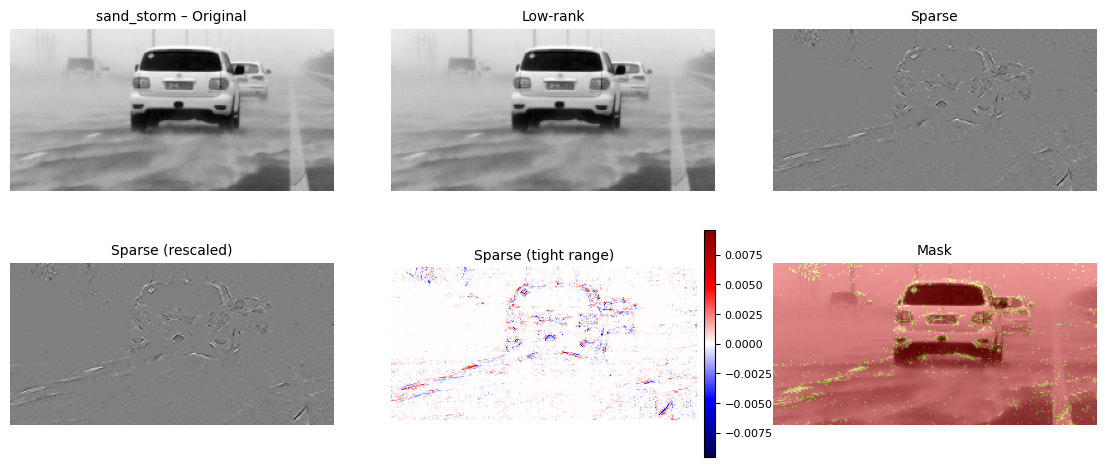


Representative (median-rank) decomposition for snow_storm


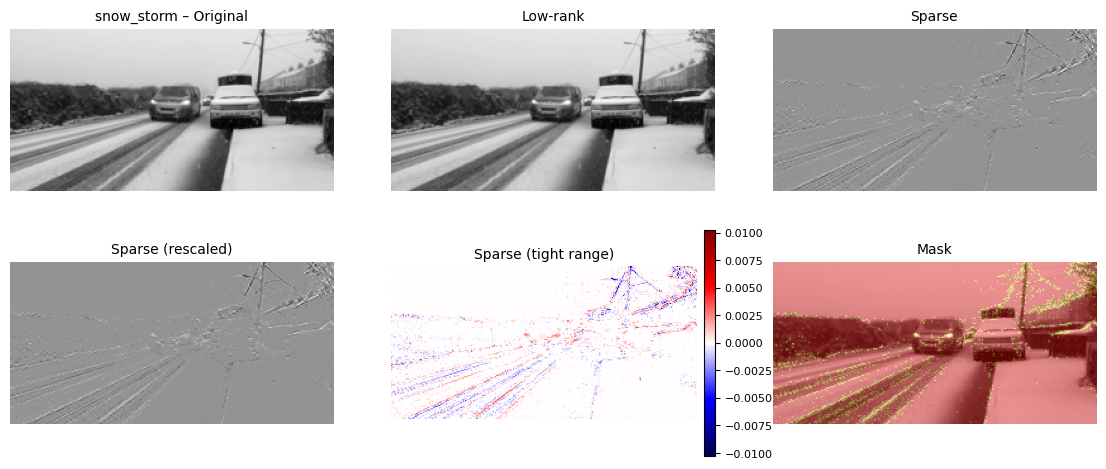

In [6]:
for weather, results in all_results.items():
    if not results:
        continue

    # Compute mean rank for this category
    ranks = np.array([
        effective_rank_from_singular_values(r["sv_L"], threshold=1e-2)
        for r in results
    ])
    mean_rank = ranks.mean()

    # Pick the example whose rank is closest to the mean
    ex = min(
        zip(results, ranks),
        key=lambda pair: abs(pair[1] - mean_rank)
    )[0]

    print(f"\nRepresentative (median-rank) decomposition for {weather}")
    visualize_decomposition_minimal(
        ex["X"], ex["L"], ex["S"],
        sparse_threshold=1e-3,
        title_prefix=f"{weather} – "
    )


### 4. Aggregate stats per weather category
This section summarizes how each weather type behaves under PCP decomposition by computing:
- Average effective rank of L: how complex the underlying scene appears after removing noise/artifacts. For each image, look at L's singular values and cont how many are signifficant. Higher rank means that the umnderlying scene needs more complexity to be represented (might be common in cluttered scenes, dust fog). Lower rank means that the scene is simpler or that the artifacts were removed cleanly (might be common in clear-weather images).
- Energy of $S$: how much of the image's total "energy" (Frobenius norm) is explained as sparse corruption. Higher energy of $S$ means that PCP is attributing more of the image to artifacts.
- Sparsity of $S$: the fraction of pixels where $|S_{ij}| > 1e^{-3}$. Higher sparsity means that more pixels are flagged as corrupted.

In [6]:
weather_stats = {}

for weather, results in all_results.items():
    if not results:
        continue

    # Reconstruction errors
    recon_errors = np.array([r["recon_error"] for r in results])

    # Effective rank of L
    ranks_L = np.array([
        effective_rank_from_singular_values(r["sv_L"], threshold=1e-2)
        for r in results
    ])

    # Energy in S and sparsity of S (per image)
    energies_S = np.array([
        sparse_energy(r["X"], r["S"]) for r in results
    ])

    sparsities_S = np.array([
        sparsity(r["S"], threshold=1e-3) for r in results
    ])

    # Store all summary stats
    weather_stats[weather] = {
        "mean_error": recon_errors.mean(),
        "std_error": recon_errors.std(),
        "mean_rank_L": ranks_L.mean(),
        "std_rank_L": ranks_L.std(),
        "mean_energy_S": energies_S.mean(),
        "std_energy_S": energies_S.std(),
        "mean_sparsity_S": sparsities_S.mean(),
        "std_sparsity_S": sparsities_S.std(),
    }

print("\nWeather category stats:")
for w, st in weather_stats.items():
    print(
        f"{w:>12} | "
        f"rank(L)={st['mean_rank_L']:.2f}±{st['std_rank_L']:.2f} | "
        f"energy(S)={st['mean_energy_S']:.3f}±{st['std_energy_S']:.3f} | "
        f"sparsity(S)={st['mean_sparsity_S']:.3f}±{st['std_sparsity_S']:.3f}"
    )



Weather category stats:
 dusttornado | rank(L)=10.83±4.95 | energy(S)=0.001±0.000 | sparsity(S)=0.051±0.016
       foggy | rank(L)=9.10±5.36 | energy(S)=0.001±0.000 | sparsity(S)=0.046±0.012
        haze | rank(L)=10.89±7.34 | energy(S)=0.001±0.000 | sparsity(S)=0.046±0.017
        mist | rank(L)=11.13±7.47 | energy(S)=0.001±0.000 | sparsity(S)=0.054±0.014
  rain_storm | rank(L)=21.29±11.57 | energy(S)=0.001±0.000 | sparsity(S)=0.053±0.014
  sand_storm | rank(L)=11.29±6.42 | energy(S)=0.001±0.000 | sparsity(S)=0.049±0.013
  snow_storm | rank(L)=26.99±11.27 | energy(S)=0.001±0.000 | sparsity(S)=0.071±0.013


In [23]:
rows = []
for weather, st in weather_stats.items():
    rows.append({
        "weather": weather,
        "mean_rank_L": st["mean_rank_L"],
        "std_rank_L": st["std_rank_L"],
        "mean_energy_S": st["mean_energy_S"],
        "std_energy_S": st["std_energy_S"],
        "mean_sparsity_S": st["mean_sparsity_S"],
        "std_sparsity_S": st["std_sparsity_S"],
        "mean_error": st["mean_error"],
        "std_error": st["std_error"],
    })

df_stats = pd.DataFrame(rows)

label_map = {
    "dusttornado": "Dust Tornado",
    "foggy": "Fog",
    "haze": "Haze",
    "mist": "Mist",
    "rain_storm": "Rain Storm",
    "sand_storm": "Sandstorm",
    "snow_storm": "Snow Storm",
}

df_stats["weather_label"] = df_stats["weather"].map(label_map)



In [45]:
# Base bar chart
chart_rank = (
    alt.Chart(df_stats)
    .mark_bar()
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_rank_L:Q", title="Mean Effective Rank of L"),
        tooltip=["weather_label", "mean_rank_L", "std_rank_L"]
    )
)

# Error bars
error_rank = (
    alt.Chart(df_stats)
    .mark_errorbar()
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_rank_L:Q", title="Mean Effective Rank of L"),
        yError="std_rank_L:Q"
    )
)

# Text labels on top of bars
labels = (
    alt.Chart(df_stats)
    .mark_text(
        align='center',
        baseline='bottom',
        dy=-2  # adjust to move text above the bar
    )
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_rank_L:Q", title="Mean Effective Rank of L"),
        text=alt.Text("mean_rank_L:Q", format=".2f")
    )
)

# Combine all layers
(chart_rank + error_rank + labels).properties(
    width=800,
    height=600,
    title="Effective Rank(L) by Weather Type"
)


alt.LayerChart(...)

In [35]:
# Bar chart
chart_energy = (
    alt.Chart(df_stats)
    .mark_bar(color="#10926b")
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_energy_S:Q", title="Mean Sparse Energy (‖S‖ / ‖X‖)"),
        tooltip=["weather_label", "mean_energy_S", "std_energy_S"]
    )
)

# Error bars
error_energy = (
    alt.Chart(df_stats)
    .mark_errorbar()
    .encode(
        x="weather_label:N",
        y="mean_energy_S:Q",
        yError="std_energy_S:Q"
    )
)

# Mean labels above bars
energy_labels = (
    alt.Chart(df_stats)
    .mark_text(
        align='center',
        baseline='bottom',
        dy=-2     # shift text slightly above the bar
    )
    .encode(
        x="weather_label:N",
        y="mean_energy_S:Q",
        text=alt.Text("mean_energy_S:Q", format=".6f")
    )
)

(chart_energy + error_energy + energy_labels).properties(
    width=400,
    height=300,
    title="Sparse Energy by Weather Type"
)


alt.LayerChart(...)

In [48]:
# Bar chart
chart_sparsity = (
    alt.Chart(df_stats)
    .mark_bar(color="#d62728")
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_sparsity_S:Q", title="Mean Sparsity"),
        tooltip=["weather_label", "mean_sparsity_S", "std_sparsity_S"]
    )
)

# Error bars
error_sparsity = (
    alt.Chart(df_stats)
    .mark_errorbar()
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_sparsity_S:Q", title="Mean Sparsity"),
        yError="std_sparsity_S:Q"
    )
)

# Labels above bars
sparsity_labels = (
    alt.Chart(df_stats)
    .mark_text(
        align='center',
        baseline='bottom',
        dy=-2  # Move text slightly above the bar
    )
    .encode(
        x=alt.X("weather_label:N", title="Weather Type"),
        y=alt.Y("mean_sparsity_S:Q", title="Mean Sparsity"),
        text=alt.Text("mean_sparsity_S:Q", format=".3f")
    )
)

(chart_sparsity + error_sparsity + sparsity_labels).properties(
    width=800,
    height=600,
    title="Sparsity of S by Weather Type"
)


alt.LayerChart(...)

In [22]:
df_image_level = []

for weather, results in all_results.items():
    for r in results:
        df_image_level.append({
            "weather": weather,
            "rank_L": effective_rank_from_singular_values(r["sv_L"]),
            "energy_S": sparse_energy(r["X"], r["S"]),
            "sparsity_S": sparsity(r["S"])
        })

df_image = pd.DataFrame(df_image_level)

alt.Chart(df_image).mark_circle(size=50).encode(
    x=alt.X("rank_L:Q", title="Effective Rank(L)"),
    y=alt.Y("energy_S:Q", title="Sparse Energy"),
    color=alt.Color("weather:N", title="Weather Type"),
    tooltip=["weather", "rank_L", "energy_S"]
).properties(
    width=400,
    height=300,
    title="Sparse Energy vs Rank(L) Colored by Weather Type"
)


alt.Chart(...)

In [13]:
all_errors = []
for weather, results in weather_stats.items():
    all_errors.append(results["mean_error"])

all_errors = np.array(all_errors)

print("Global Reconstruction Error Stats:")
print(f"Mean: {all_errors.mean():.3e}")
print(f"Min:  {all_errors.min():.3e}")
print(f"Max:  {all_errors.max():.3e}")

Global Reconstruction Error Stats:
Mean: 4.298e-05
Min:  1.963e-05
Max:  5.244e-05


### 5. Mean singular value curves per weather category
Figure shows the mean singular value spectra of the low-rank component $L$ across weather types. Snow storms and rain storms exhibit a slower decay, indicating higher effective rank, whereas foggy and haze conditions have faster decays, suggesting more compact underlying structure.

In [38]:
import pandas as pd
import numpy as np
import altair as alt

K = 50  # number of singular values to keep

rows = []

for weather, results in all_results.items():
    if not results:
        continue

    # Stack top-K singular values of L
    sv_stack = np.stack([r["sv_L"][:K] for r in results], axis=0)  # (n_images, K)
    sv_mean = sv_stack.mean(axis=0)

    for i, val in enumerate(sv_mean, start=1):
        rows.append({
            "weather": weather,
            "sv_index": i,
            "sv_value": val
        })

df_sv = pd.DataFrame(rows)
df_sv["weather_label"] = df_sv["weather"].map(label_map)


In [46]:
chart_sv = (
    alt.Chart(df_sv)
    .mark_line(point=False)
    .encode(
        x=alt.X(
            "sv_index:Q",
            title="Singular Value Index (k)",
            axis=alt.Axis(tickMinStep=5)
        ),
        y=alt.Y(
            "sv_value:Q",
            title="Mean Singular Value of L",
            scale=alt.Scale(type="log")  # log-scale is usually best here
        ),
        color=alt.Color(
            "weather_label:N",
            title="Weather Type",
            legend=alt.Legend(orient="right")
        ),
        tooltip=[
            alt.Tooltip("weather_label:N", title="Weather"),
            alt.Tooltip("sv_index:Q", title="Index k"),
            alt.Tooltip("sv_value:Q", title="Mean σ_k", format=".3e")
        ]
    )
    .properties(
        width=1000,
        height=600,
        title="Mean Singular Value Spectra of L (Top-50, by Weather Type)"
    )
    .interactive()  # zoom/pan
)

chart_sv


alt.Chart(...)